This notebook replicates the main results from sec. 2.1 of [1], and in particular both plots shown in fig. 1.

[1]: "Scaling Laws of Associative Memory Retrieval", Romani, Tsodyks et al., Neural Computation (2013).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl2latex import mpl2latex, latex_figsize
from tqdm.notebook import tqdm

In [2]:
#---Parameters---#

N = 3000 #Number of neurons
L = 16 #Number of patterns

f = 0.1 #Sparseness

T = 0.015 #Thresholds are uniformely sampled from the interval [-T, T]
init_thresholds = np.random.uniform(-T, T, size=N)

n_steps = 1000
ts = np.arange(n_steps) #time steps

Tth = 30

J0min = 0.6 #Minimum value for J0 (global inhibition)
J0max = 1.2 #Maximum value for J0
TJ0   = 25  #Period for J0 oscillations between min and max

J0 = np.sin(2 * np.pi / TJ0 * ts) * (J0max - J0min) + J0min #(oscillating) global inhibition

Dth = 4.2 * T #Strength of synaptic adaptation

In [3]:
#Generate sparse patterns
patterns = np.zeros((L, N), dtype=int)
mask = np.random.uniform(0, 1, size=(L, N)) < f #patterns[mu, i] = 1 with probability f
patterns[mask] = 1

#Compute weights
synaptic_mtx = 1./(N * f * (1.-f)) * ((patterns - f).T @ (patterns - f))

**Dynamics**:
$$\begin{align}V_i(t+1) &= \Theta\Big(\sum_{\substack{j=1\\ j \neq i}}^N \mathrm{J}_{ij} V_j(t) - \frac{J_0}{N f} \sum_{j=1}^N V_j(t) -\mathrm{th}_i(t)\Big)\\
\mathrm{th}_i(t+1) &= \mathrm{th}_i(t) - \frac{\mathrm{th}_i(t) - \mathrm{th}_i(0) - D_{\mathrm{th}} V_i(t)}{T_{\mathrm{th}}}
\end{align}$$

In [4]:
def order_params(neuro_state):
    """
    Compute the overlap of the @neuro_state with each of the L patterns.
    """
    
    return (patterns - f) @ neuro_state / (N * f * (1.-f))

In [5]:
#---Initialize---#
curr_thresholds  = init_thresholds.copy()
curr_neuro_state = patterns[0].copy() #initialize to 1st pattern

neuro_order_states = np.zeros((L, n_steps)) #Store order parameters at each time here

#---Simulate dynamics---#
for idx, t in enumerate(tqdm(ts)):   
    next_neuro_state = synaptic_mtx @ curr_neuro_state - J0[idx] / (N * f) * np.sum(curr_neuro_state) - curr_thresholds
    next_neuro_state = np.heaviside(next_neuro_state, 0)
    
    curr_thresholds = curr_thresholds - (curr_thresholds - init_thresholds - Dth * curr_neuro_state) / Tth    
    curr_neuro_state = next_neuro_state.copy()

    neuro_order_states[:, idx] = order_params(curr_neuro_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

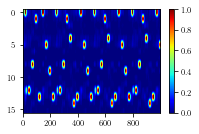

In [6]:
#Plot dynamics
with mpl2latex(True):
    fig, ax = plt.subplots(figsize=latex_figsize(wf=0.7, columnwidth=318.67))
    plt.imshow(neuro_order_states, aspect='auto', cmap='jet', vmin=0, vmax=1)
    plt.colorbar()
    
    
    
    ax.patch.set_facecolor('white')
    plt.savefig("Plots/network_model.pdf", transparent=True, bbox_inches='tight')
    
    plt.show()

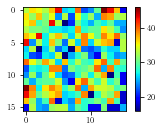

In [8]:
#Plot overlaps
with mpl2latex(True):
    fig, ax = plt.subplots(figsize=latex_figsize(wf=0.7, columnwidth=318.67))
    
    overlaps = patterns @ patterns.T
    average_entries = (np.sum(overlaps, axis=1) - np.diag(overlaps)) / (L - 1)
    np.fill_diagonal(overlaps, average_entries) #Substitute in the diagonal the average value of the other entries
    plt.imshow(overlaps, cmap='jet')
    plt.colorbar()
    
    ax.patch.set_facecolor('white')
    plt.savefig("Plots/network_overlaps.pdf", transparent=True, bbox_inches='tight')